Cell 1: Dataset Splitting

Installed and used split-folders to divide your augmented Alzheimer MRI dataset into:

70% training

15% validation

15% testing


In [3]:
# Install split-folders if not already installed
%pip install split-folders
# pyright: ignore[reportMissingImports]
import splitfolders

# Path to your augmented dataset (use raw strings)
input_folder = r"D:\Dataset-MRI-img\AugmentedAlzheimerDataset"

# Output folder where split data will be stored
output_folder = r"D:\Split data"

# Perform 70% train, 15% validation, 15% test split
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.7, 0.15, 0.15)
)


Note: you may need to restart the kernel to use updated packages.


Copying files: 33984 files [02:08, 263.70 files/s]


Cell 2: Data Preparation

Set dataset paths: train, val, test folders.

Applied image transformations:

Resize → convert all images to 224×224 (standard input for VGG16).

ToTensor → scales pixel values [0–255] to [0–1].

Created PyTorch datasets using ImageFolder (loads images by folder names as labels).

Built DataLoaders for efficient batching & shuffling.

Printed class info → num_classes and mapping of class names to indices.

In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ✅ Paths to your split dataset
TRAIN_DIR = r"D:\Split data\train"
VAL_DIR   = r"D:\Split data\val"
TEST_DIR  = r"D:\Split data\test"

# ✅ Parameters
BATCH_SIZE = 32
IMG_SIZE = 224  # VGG16 standard input

# ✅ Transformations: rescale and resize (PyTorch expects 0-1 floats)
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # automatically scales 0-255 to 0-1
])

# ✅ Load datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
val_dataset   = datasets.ImageFolder(root=VAL_DIR, transform=data_transforms)
test_dataset  = datasets.ImageFolder(root=TEST_DIR, transform=data_transforms)

# ✅ DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ✅ Class info
num_classes = len(train_dataset.classes)
class_indices = train_dataset.class_to_idx
print("num_classes:", num_classes)
print("class_indices:", class_indices)

# Optional: quick sanity check
for images, labels in train_loader:
    print("Batch images shape:", images.shape)  # [batch_size, 3, 224, 224]
    print("Batch labels shape:", labels.shape)
    break


num_classes: 4
class_indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


Cell 3: GPU Check

Checked if CUDA GPU is available.

Printed GPU details → confirms your model can run on GPU (much faster).

In [5]:
import torch

# Check if CUDA (GPU) is available
gpu_available = torch.cuda.is_available()
print("GPU available:", gpu_available)

# Number of GPUs
print("Number of GPUs:", torch.cuda.device_count())

# Name of the current GPU (if available)
if gpu_available:
    print("Current GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))


GPU available: True
Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


Cell 4: Model Setup (VGG16)

Loaded pre-trained VGG16 (from ImageNet).

Froze convolutional layers (feature extractor part) → only train the classifier part.

Modified classifier head:

Flatten layer

Linear(25088 → 256) + ReLU + Dropout

Linear(256 → num_classes) → output layer for your dataset (4 classes).

Defined:

Loss function: CrossEntropyLoss (multi-class classification).

Optimizer: Adam (training only classifier parameters).

Printed model summary to confirm architecture.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# ✅ Device setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Load pre-trained VGG16 (without classifier)
vgg16 = models.vgg16(pretrained=True)

# Freeze all convolutional layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# ✅ Modify classifier to match your number of classes
num_classes = 4  # replace with your actual number

vgg16.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 256),  # 25088 = 512*7*7 for VGG16 input 224x224
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)  # output layer
)

# Move model to GPU if available
vgg16 = vgg16.to(device)

# ✅ Loss and optimizer
criterion = nn.CrossEntropyLoss()  # for multi-class classification
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=1e-4)  # only train classifier

# Optional: model summary (requires torchsummary)
from torchsummary import summary
summary(vgg16, (3, 224, 224))


Using device: cuda


d:\COLLEGE\Major Project\Code\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\COLLEGE\Major Project\Code\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Cell 5: Training Loop

Defined training for 20 epochs.

Implemented:

Training phase:

Forward pass, compute loss, backward pass, optimizer update.

Collected loss and accuracy.

Validation phase:

Model in eval() mode, no gradient updates.

Computed validation loss and accuracy.

Stored all metrics in a history dictionary → useful for plotting curves later.

Printed per-epoch results:

Train Loss, Train Acc, Val Loss, Val Acc.

Train the Model

In [5]:
import torch
from tqdm import tqdm  # for progress bar

EPOCHS = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# History dictionary to store metrics
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # --------- Training ---------
    vgg16.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total

    # --------- Validation ---------
    vgg16.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= val_total
    val_acc = val_correct / val_total

    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} -> "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/20 [Val]: 100%|██████████| 160/160 [00:45<00:00,  3.55it/s]


Epoch 1/20 -> Train Loss: 0.7650, Train Acc: 0.6674, Val Loss: 0.5450, Val Acc: 0.7732


Epoch 2/20 [Val]: 100%|██████████| 160/160 [00:37<00:00,  4.22it/s]


Epoch 2/20 -> Train Loss: 0.5019, Train Acc: 0.7943, Val Loss: 0.4643, Val Acc: 0.8087


Epoch 3/20 [Val]: 100%|██████████| 160/160 [00:38<00:00,  4.19it/s]


Epoch 3/20 -> Train Loss: 0.3893, Train Acc: 0.8485, Val Loss: 0.3550, Val Acc: 0.8634


Epoch 4/20 [Val]: 100%|██████████| 160/160 [00:38<00:00,  4.17it/s]


Epoch 4/20 -> Train Loss: 0.3100, Train Acc: 0.8810, Val Loss: 0.2953, Val Acc: 0.8854


Epoch 5/20 [Val]: 100%|██████████| 160/160 [00:53<00:00,  2.99it/s]


Epoch 5/20 -> Train Loss: 0.2484, Train Acc: 0.9114, Val Loss: 0.2461, Val Acc: 0.9086


Epoch 6/20 [Val]: 100%|██████████| 160/160 [00:38<00:00,  4.13it/s]


Epoch 6/20 -> Train Loss: 0.2084, Train Acc: 0.9259, Val Loss: 0.2298, Val Acc: 0.9137


Epoch 7/20 [Val]: 100%|██████████| 160/160 [00:39<00:00,  4.04it/s]


Epoch 7/20 -> Train Loss: 0.1705, Train Acc: 0.9428, Val Loss: 0.1981, Val Acc: 0.9258


Epoch 8/20 [Val]: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


Epoch 8/20 -> Train Loss: 0.1459, Train Acc: 0.9520, Val Loss: 0.1887, Val Acc: 0.9272


Epoch 9/20 [Val]: 100%|██████████| 160/160 [00:38<00:00,  4.14it/s]


Epoch 9/20 -> Train Loss: 0.1236, Train Acc: 0.9586, Val Loss: 0.1690, Val Acc: 0.9400


Epoch 10/20 [Val]: 100%|██████████| 160/160 [00:48<00:00,  3.32it/s]


Epoch 10/20 -> Train Loss: 0.1067, Train Acc: 0.9648, Val Loss: 0.1607, Val Acc: 0.9411


Epoch 11/20 [Val]: 100%|██████████| 160/160 [00:46<00:00,  3.42it/s]


Epoch 11/20 -> Train Loss: 0.0897, Train Acc: 0.9720, Val Loss: 0.1646, Val Acc: 0.9398


Epoch 12/20 [Val]: 100%|██████████| 160/160 [00:36<00:00,  4.36it/s]


Epoch 12/20 -> Train Loss: 0.0776, Train Acc: 0.9759, Val Loss: 0.1614, Val Acc: 0.9407


Epoch 13/20 [Val]: 100%|██████████| 160/160 [00:45<00:00,  3.54it/s]


Epoch 13/20 -> Train Loss: 0.0680, Train Acc: 0.9801, Val Loss: 0.1453, Val Acc: 0.9476


Epoch 14/20 [Val]: 100%|██████████| 160/160 [00:56<00:00,  2.83it/s]


Epoch 14/20 -> Train Loss: 0.0689, Train Acc: 0.9778, Val Loss: 0.1422, Val Acc: 0.9502


Epoch 15/20 [Val]: 100%|██████████| 160/160 [00:49<00:00,  3.25it/s]


Epoch 15/20 -> Train Loss: 0.0613, Train Acc: 0.9814, Val Loss: 0.1456, Val Acc: 0.9486


Epoch 16/20 [Val]: 100%|██████████| 160/160 [01:24<00:00,  1.90it/s]


Epoch 16/20 -> Train Loss: 0.0501, Train Acc: 0.9848, Val Loss: 0.1328, Val Acc: 0.9533


Epoch 17/20 [Val]: 100%|██████████| 160/160 [00:50<00:00,  3.16it/s]


Epoch 17/20 -> Train Loss: 0.0481, Train Acc: 0.9855, Val Loss: 0.1353, Val Acc: 0.9545


Epoch 18/20 [Val]: 100%|██████████| 160/160 [00:37<00:00,  4.24it/s]


Epoch 18/20 -> Train Loss: 0.0434, Train Acc: 0.9866, Val Loss: 0.1412, Val Acc: 0.9513


Epoch 19/20 [Val]: 100%|██████████| 160/160 [00:37<00:00,  4.23it/s]


Epoch 19/20 -> Train Loss: 0.0431, Train Acc: 0.9870, Val Loss: 0.1543, Val Acc: 0.9457


Epoch 20/20 [Val]: 100%|██████████| 160/160 [00:37<00:00,  4.25it/s]

Epoch 20/20 -> Train Loss: 0.0368, Train Acc: 0.9890, Val Loss: 0.1346, Val Acc: 0.9531


Save the Best Model

In [7]:
best_val_acc = 0.0

for epoch in range(EPOCHS):
    # ... training + validation ...
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(vgg16.state_dict(), "best_vgg16_alzheimer.pth")
        print(f"** Best model saved at epoch {epoch+1} with val_acc = {best_val_acc:.4f}")


NameError: name 'EPOCHS' is not defined

You can now load this saved model anytime for testing, inference, or deployment

In [8]:
vgg16.load_state_dict(torch.load("best_vgg16_alzheimer.pth"))
vgg16.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Plot Learning Curves

NameError: name 'history' is not defined

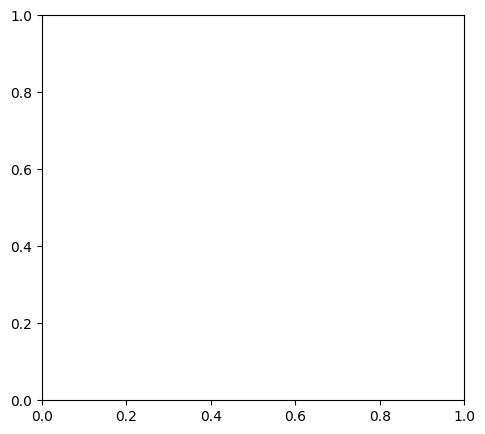

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Accuracy Curve')
plt.show()


Test the Model

In [10]:
vgg16.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")


Test Accuracy: 0.9555


1️⃣ Confusion Matrix

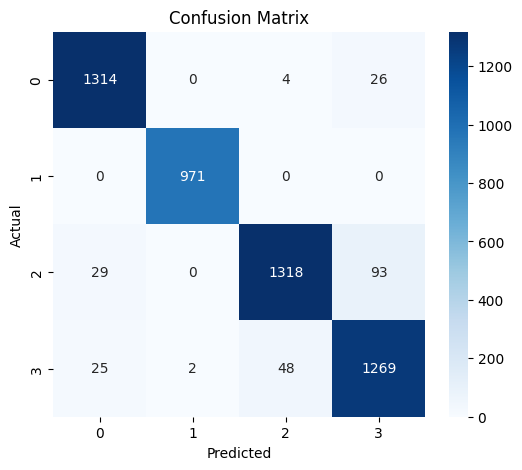

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_labels = []
all_preds = []

vgg16.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


2️⃣ Classification Report

In [12]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['Class0','Class1','Class2','Class3']))


              precision    recall  f1-score   support

      Class0       0.96      0.98      0.97      1344
      Class1       1.00      1.00      1.00       971
      Class2       0.96      0.92      0.94      1440
      Class3       0.91      0.94      0.93      1344

    accuracy                           0.96      5099
   macro avg       0.96      0.96      0.96      5099
weighted avg       0.96      0.96      0.96      5099



3️⃣ ROC Curve / AUC

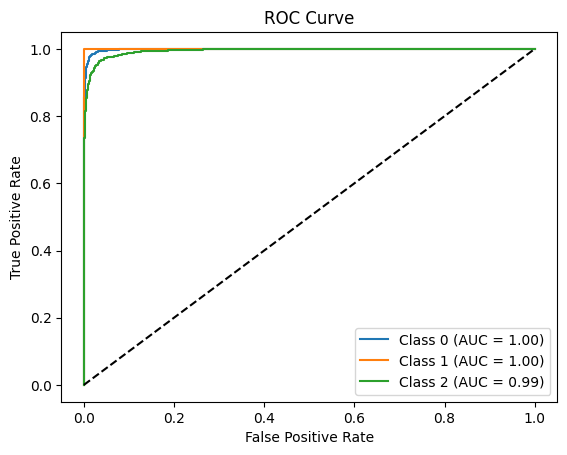

In [14]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Example for 3 classes
num_classes = 3  # change if you have more
y_true = label_binarize(all_labels, classes=list(range(num_classes)))

y_score = []
vgg16.eval()
with torch.no_grad():  # disables gradient computation
    for images, _ in test_loader:
        images = images.to(device)
        outputs = torch.nn.functional.softmax(vgg16(images), dim=1)
        y_score.append(outputs.cpu().detach().numpy())  # detach here

y_score = np.vstack(y_score)

# Plot ROC curves
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


4️⃣ Save the Model

In [15]:
torch.save(vgg16.state_dict(), "best_vgg16_alzheimer.pth")

reload later

In [16]:
vgg16.load_state_dict(torch.load("best_vgg16_alzheimer.pth"))
vgg16.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

5️⃣ Inference on New Images

In [26]:
from PIL import Image
from torchvision import transforms

# Preprocessing (match your training)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# Load image (change path to the image you want to test)
img = Image.open(r"D:\Split data\test\VeryMildDemented\1b8d18bb-0a28-476a-8783-5aeb91fb036c.jpg").convert('RGB')
img = transform(img).unsqueeze(0).to(device)

# Class mapping
class_indices = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
index_to_class = {v: k for k, v in class_indices.items()}

# Run inference
vgg16.eval()
with torch.no_grad():
    output = vgg16(img)
    _, pred = torch.max(output, 1)
    predicted_index = pred.item()
    predicted_class = index_to_class[predicted_index]

print(f"Predicted Class Index: {predicted_index}")
print(f"Predicted Class Name: {predicted_class}")


Predicted Class Index: 3
Predicted Class Name: VeryMildDemented
